给定IRIS数据集，该数据集有三类目标，每个类别有50个样本，每个样本有四维特征。实验时每个类别随机选30个样本进行训练，另外20个样本用于测试。
1. 以感知器算法为基础分类算法，编写一个OVO多类分类器算法，对上述数据集进行实验，分析结果。
2. 编写Softmax算法实现多类别分类，对上述数据集进行实验，分析结果。


Google Colab cpu
OVO-感知器——————————————————————————————————————————————————————————————————————————————————
OVO 感知器得 : 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 2 2 2 2 2 2 1 2 2 2 1 2 1 2 2 2 2 2]

Expected : 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

bule-predict,ori-expected


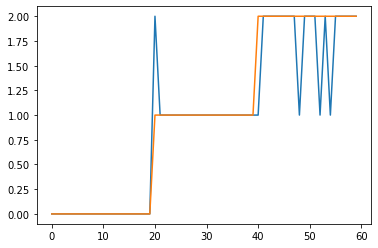

Accuracy = 0.9166666666666666


In [79]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import copy
import random
import time

import os
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from torchvision.transforms import ToTensor


device = 'cuda' if torch.cuda.is_available() else 'cpu'

iris = datasets.load_iris()


class Iris_Data_Set(Dataset):
  def __init__(self,X,Y,n = 3):
    self.X = X
    self.Y_ex = Y
    self.size = len(Y)
    self.Y = np.zeros((len(Y),n)).astype(np.float32)
    for i in range(self.size):
        self.Y[i,Y[i]] += 1
  def __len__(self):
    return len(self.Y)
  def __getitem__(self,idx):
    return self.X[idx],self.Y[idx]

X = iris.data
Y = iris.target
n = len(Y)
permutation = np.random.permutation(n)
X = X[permutation].tolist()
Y = Y[permutation].tolist()
X_train = [[],[],[]]
Y_train = [[],[],[]]
X_test = [[],[],[]]
Y_test = [[],[],[]]
cnt = [0,0,0]
for i in range(n):
  if cnt[Y[i]] < 0.6 * (n // 3):
    X_train[Y[i]].append(X[i])
    Y_train[Y[i]].append(Y[i])
    cnt[Y[i]] += 1
  else:
    X_test[Y[i]].append(X[i])
    Y_test[Y[i]].append(Y[i])

def sign(num):
  if num>=0:
    return 1
  else:
    return -1

def Pocket(x, y, max_time=10000):
  for xi in x:
    xi.append(1)
  X = x
  correct_Y = y
  
  w = np.zeros(5)
  count = 0
  
  min_w = w
  min_error = len(X)

  while count < max_time:
    count += 1
    error = 0
    while count < max_time:
      count += 1
      error = 0
      flag = 0
      error_list = []
      for i in range(0,len(X)):
        now_Y = sign(np.dot(w,X[i]))
        if correct_Y[i] == now_Y:
          continue
        else:
          error_list.append([X[i],correct_Y[i]])
        error += 1

      if error == 0:
        min_error = 0
        break
      else:
        if error < min_error:
          min_error = error
          min_w = w

      error_sample = random.choice(error_list)
      w += [i * error_sample[1] for i in error_sample[0]]

  #print("\nPocket")
  #print("Min_w equal to:",min_w)
  #print("under this w error equal to:",min_error)
  #print("iteration:",count)
  return w  


def single_predict(w,x):
    if isinstance(x,np.ndarray):
        x = x.tolist()
    for xi in x:
        xi.append(1)    
    x = np.array(x)
    predict = np.sign(w.dot(x.T))
    return predict

def OVO(X_train,Y_train,X_test,Y_test):
    n_class = len(Y_train)
    n_test = len(Y_test[0])
    Ws = {}
    result = np.zeros((n_test * n_class,n_class))
    for i in range(n_class):
      for j in range(i + 1,n_class):
        X = copy.deepcopy(X_train[i])
        X.extend(copy.deepcopy(X_train[j]))
        Y = [1 for k in range(len(X_train[i]))]
        Y.extend([-1 for k in range(len(X_train[j]))])
        Ws[(i,j)] = Pocket(X,Y)
    for i,j in Ws.keys():
      X = copy.deepcopy(X_test[0])
      for k in range(1,n_class):
        X.extend(copy.deepcopy(X_test[k]))
        
      predict = single_predict(Ws[(i,j)],X)
      for k,res in zip(range(len(predict)),predict):
          if res == 1:
            result[k,i] += 1
          else:
            result[k,j] += 1
    expected_result = copy.deepcopy(Y_test[0])
    for i in range(1,n_class):
        expected_result.extend(Y_test[i])
    final_result = np.argmax(result,axis=1)
    print("OVO-感知器——————————————————————————————————————————————————————————————————————————————————")
    print("OVO 感知器得 : \n{}\n".format(final_result))
    print("Expected : \n{}\n".format(expected_result))
    print("bule-predict,ori-expected")
    plt.plot(final_result)
    plt.plot(expected_result)
    plt.show()
    
    miss_predict = np.absolute(final_result - expected_result)
    error_num = np.count_nonzero(miss_predict)
    total_num = len(expected_result) 
    print("Accuracy = " + str(1 - error_num / total_num))

OVO(X_train,Y_train,X_test,Y_test)

def gen_data():
  iris = ds.load_iris()
  X = iris.data.astype(np.float32)
  Y = iris.target
  X_train = np.concatenate((X[0:30,],X[70:100,],X[100:130,])).astype(np.float32)
  Y_train = np.concatenate((Y[0:30],Y[70:100],Y[100:130]))
  X_test = np.concatenate((X[30:50,],X[50:70,],X[130:150,])).astype(np.float32)
  Y_test = np.concatenate((Y[30:50],Y[50:70],Y[130:150]))
  return (Iris_Data_Set(X_train,Y_train),Iris_Data_Set(X_test,Y_test))


train_data,test_data = gen_data()
train_dataloader = DataLoader(train_data, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

learning_rate = 1e-2
epoch = 40

model = nn.Sequential(nn.Linear(4, 3), nn.Softmax())
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_arr = []
acc_arr = []



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


acc


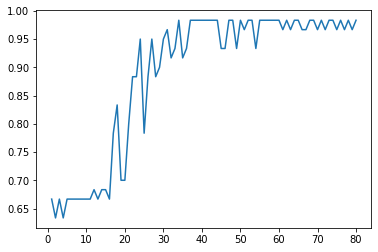

epoch-loss


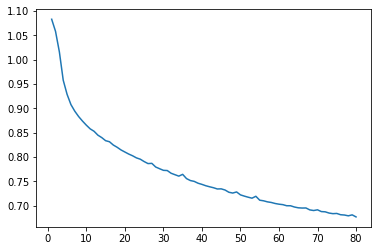

In [81]:
for i in range(epoch):
    data_loader = train_dataloader
    total = len(data_loader.dataset)
    for batch,(X,Y) in enumerate(data_loader):
      predict = model(X)
      loss = loss_fn(predict,Y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
    data_loader = test_dataloader  
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    test_loss, correct = 0, 0
    with torch.no_grad():
      for X,Y in data_loader:
        predict = model(X)
        test_loss += loss_fn(predict, Y).item()
        correct += 1 if predict.argmax() == Y.argmax() else 0
    test_loss /= num_batches
    correct /= size
    loss_arr.append(test_loss)
    acc_arr.append(correct)
print("acc")
plt.plot(range(1,len(acc_arr)+1), acc_arr)
plt.show()
print("epoch-loss")
plt.plot(range(1,len(loss_arr)+1), loss_arr)
plt.show()


## 给定MNIST数据集，该数据集每个样本为28*28大小的灰度图像，有0到9共10个类别的手写体数字

数据下载与整理

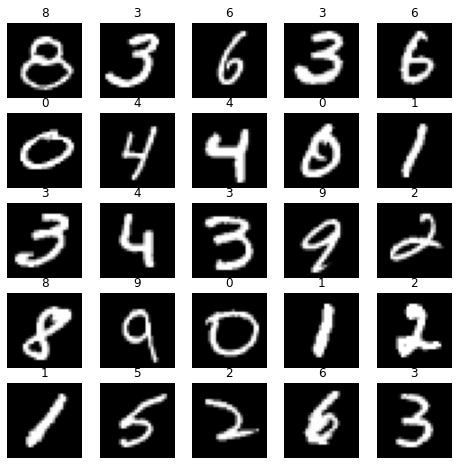

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
import time

import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
device = 'cuda' if torch.cuda.is_available() else 'cpu'

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(str(label))
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()



训练

Epoch 1 
loss: 2.306483  [    0/60000]


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss: 1.605725  [25600/60000]
loss: 1.556901  [51200/60000]
Test Test Accuracy: 92.0%, loss: 1.553939 

Train Test Accuracy: 91.8%, loss: 1.558438 

Epoch 2 
loss: 1.583217  [    0/60000]
loss: 1.549529  [25600/60000]
loss: 1.559494  [51200/60000]
Test Test Accuracy: 92.3%, loss: 1.545281 

Train Test Accuracy: 92.5%, loss: 1.546718 

Epoch 3 
loss: 1.536738  [    0/60000]
loss: 1.535031  [25600/60000]
loss: 1.551353  [51200/60000]
Test Test Accuracy: 92.6%, loss: 1.540801 

Train Test Accuracy: 93.0%, loss: 1.539890 

Epoch 4 
loss: 1.554902  [    0/60000]
loss: 1.541303  [25600/60000]
loss: 1.566595  [51200/60000]
Test Test Accuracy: 92.7%, loss: 1.539832 

Train Test Accuracy: 93.1%, loss: 1.537142 

Epoch 5 
loss: 1.512740  [    0/60000]
loss: 1.517292  [25600/60000]
loss: 1.511230  [51200/60000]
Test Test Accuracy: 92.8%, loss: 1.539567 

Train Test Accuracy: 93.6%, loss: 1.532488 

Epoch 6 
loss: 1.540583  [    0/60000]
loss: 1.529828  [25600/60000]
loss: 1.554848  [51200/60000]


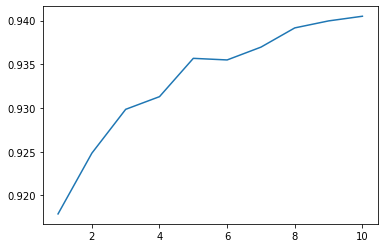

train_loss


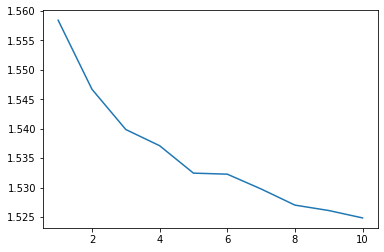

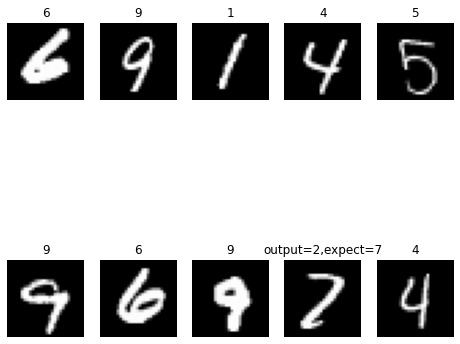

In [89]:
def test(dataloader,model,loss_fn,loss_arr,acc_arr,flag):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  loss_arr.append(test_loss)
  acc_arr.append(correct)
  print(flag,end=' ')
  print(f"Test Accuracy: {(100*correct):>0.1f}%, loss: {test_loss:>8f} \n")

batch_size = 256
total_epoch = 10
learning_rate = 1e-2

training_dataloader = DataLoader(training_data,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=256,shuffle=True)
train_v_dataloader = DataLoader(training_data,batch_size=256,shuffle=True)
train_loss = []
train_acc = []
test_loss = []
test_acc = []

model = nn.Sequential(nn.Flatten(), nn.Linear(784,10), nn.Softmax())

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in range(1,total_epoch+1):
  print("Epoch {} ".format(i))
  size = len(training_dataloader.dataset)
  for batch, (X, y) in enumerate(training_dataloader):
    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

  test(test_dataloader,model,loss_fn,test_loss,test_acc,'Test')
  test(train_v_dataloader,model,loss_fn,train_loss,train_acc,'Train')

print("train_acc")
plt.plot(range(1,11),train_acc)
plt.show()
print("train_loss")
plt.plot(range(1,11),train_loss)
plt.show()

figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 2
for i in range(1, cols * rows + 1):
  sample = next(iter(train_v_dataloader))
  img,label = sample
  figure.add_subplot(rows, cols, i)
  predict = model.forward(img).argmax(1)
  if predict[i] == label[i]:
    plt.title("{}".format(label[i]))
  else:
    plt.title("output={},expect={}".format(predict[i],label[i]))
  plt.axis("off")
  plt.imshow(img[i].squeeze(), cmap="gray")
plt.show()